## Setup & Meta Features

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pyarrow.parquet as pq
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split

In [ ]:
# Mount
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH_MERGED = "/content/drive/MyDrive/BT4222 Group 3/1. Data Preparation/Data/features_engineered/user_behavior_data_sampled_parsed_features_merged.parquet"
queries_table_selected_cols = pq.read_table(DATA_PATH_MERGED,
                     columns=['nunique_cats_1', 'nunique_cats_2', 'nunique_cats_3', 'nunique_cats_4', 'history_len', 'avg_log_cat_1_popularity',
                              'click_ratio', 'cart_ratio', 'order_ratio', 'user_ratio_cluster',
                              'avg_interaction_time_gap', 'std_time_gap', 'max_gap', 'total_time_decay', 'avg_time_decay'])

meta_df = pd.DataFrame(queries_table_selected_cols.to_pydict())
meta_df = meta_df.fillna(0)
meta_df.head()

,nunique_cats_1,nunique_cats_2,nunique_cats_3,nunique_cats_4,history_len,avg_log_cat_1_popularity,click_ratio,cart_ratio,order_ratio,user_ratio_cluster,avg_interaction_time_gap,std_time_gap,max_gap,total_time_decay,avg_time_decay
0,5.0,5.0,7.0,8.0,55,4.762177,0.490909,0.436364,0.072727,0,1.739381e+04,7.167836e+04,494313.0,77.651114,1.437984
1,5.0,6.0,7.0,7.0,14,4.700755,0.071429,0.571429,0.357143,1,1.663857e+06,3.793739e+06,14061983.0,15.874897,1.221146
2,1.0,1.0,1.0,1.0,2,4.581677,1.000000,0.000000,0.000000,2,0.000000e+00,0.000000e+00,0.0,0.999994,0.999994
3,1.0,4.0,10.0,10.0,149,4.950861,0.993289,0.006711,0.000000,2,2.799236e+03,1.579450e+04,154781.0,143.007014,0.966264
4,13.0,25.0,52.0,58.0,312,4.924904,0.605769,0.246795,0.147436,2,7.750489e+04,3.143299e+05,2280803.0,323.278000,1.039479


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the meta_df features
# Ensure meta_df is a DataFrame with numeric types before scaling
scaled_meta_features = scaler.fit_transform(meta_df)

# Convert the scaled features back to a DataFrame (optional, but good for inspection)
meta_df_scaled = pd.DataFrame(scaled_meta_features, columns=meta_df.columns)
display(meta_df_scaled.head())

,nunique_cats_1,nunique_cats_2,nunique_cats_3,nunique_cats_4,history_len,avg_log_cat_1_popularity,click_ratio,cart_ratio,order_ratio,user_ratio_cluster,avg_interaction_time_gap,std_time_gap,max_gap,total_time_decay,avg_time_decay
0,-0.540058,-0.663280,-0.567826,-0.523245,-0.110660,0.259030,0.629553,0.131201,-0.770206,-1.177498,-0.382913,-0.602385,-0.721727,0.025115,0.694852
1,-0.540058,-0.586436,-0.567826,-0.562187,-0.534707,0.178524,-0.811562,0.664764,0.381855,-0.311628,1.131880,2.694827,2.774222,-0.525124,0.210407
2,-1.210136,-0.970657,-0.840298,-0.795837,-0.658818,0.022447,2.378522,-1.592618,-1.064797,0.554242,-0.398916,-0.665882,-0.849095,-0.657614,-0.283677
3,-1.210136,-0.740124,-0.431590,-0.445362,0.861543,0.506341,2.355465,-1.566105,-1.064797,0.554242,-0.396341,-0.651890,-0.809213,0.607238,-0.359035
4,0.800097,0.873601,1.475719,1.423840,2.547386,0.472319,1.024152,-0.617675,-0.467589,0.554242,-0.327609,-0.387430,-0.261406,2.212906,-0.195461


In [ ]:
# Convert the scaled numpy array to a PyTorch tensor
meta_features_tensor = torch.tensor(scaled_meta_features, dtype=torch.float32)

print(f"Shape of meta_features_tensor: {meta_features_tensor.shape}")
print(f"First 5 rows of meta_features_tensor:\n{meta_features_tensor[:5]}")

Shape of meta_features_tensor: torch.Size([173831, 15])
First 5 rows of meta_features_tensor:
tensor([[-0.5401, -0.6633, -0.5678, -0.5232, -0.1107,  0.2590,  0.6296,  0.1312,
         -0.7702, -1.1775, -0.3829, -0.6024, -0.7217,  0.0251,  0.6949],
        [-0.5401, -0.5864, -0.5678, -0.5622, -0.5347,  0.1785, -0.8116,  0.6648,
          0.3819, -0.3116,  1.1319,  2.6948,  2.7742, -0.5251,  0.2104],
        [-1.2101, -0.9707, -0.8403, -0.7958, -0.6588,  0.0224,  2.3785, -1.5926,
         -1.0648,  0.5542, -0.3989, -0.6659, -0.8491, -0.6576, -0.2837],
        [-1.2101, -0.7401, -0.4316, -0.4454,  0.8615,  0.5063,  2.3555, -1.5661,
         -1.0648,  0.5542, -0.3963, -0.6519, -0.8092,  0.6072, -0.3590],
        [ 0.8001,  0.8736,  1.4757,  1.4238,  2.5474,  0.4723,  1.0242, -0.6177,
         -0.4676,  0.5542, -0.3276, -0.3874, -0.2614,  2.2129, -0.1955]])


## cleaning users & candidates

In the queries dataframe, there are candidate lists which are empty, and numbers represented as strings, which we are interested in converting. The

In [ ]:
# flattening the candidate_wid_list to candidate & user pairs
queries_table_only_users_and_candidates = pq.read_table(DATA_PATH_MERGED,
                     columns=['candidate_wid_list', 'candidate_label_list_int'])
users_and_candidates_df = pd.DataFrame(queries_table_only_users_and_candidates.to_pydict())
users_and_candidates_df.head()

,candidate_wid_list,candidate_label_list_int
0,"[36098226, 82122191, 34768767, 71429327, 87635...","[1, 0, 0, 0, 0]"
1,"[30857980, 44577431, 82696473, 94722703, 51139...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[42155506, 90092899, 66647496, 92302381, 61552...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[97234676, 83859812, 90043344, 51562568, 19973...","[1, 0, 0, 0, 0]"
4,"[19711065, 83045333, 65555812, 23738187, 84489...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Re-read users_and_candidates_df from its source to ensure a clean state with unique columns
queries_table_only_users_and_candidates = pq.read_table(DATA_PATH_MERGED,
                     columns=['candidate_wid_list', 'candidate_label_list_int'])
users_and_candidates_df = pd.DataFrame(queries_table_only_users_and_candidates.to_pydict())

# Now proceed with adding the user_id and flattening
users_and_candidates_df = users_and_candidates_df.reset_index().rename(columns={'index': 'user_id'})
users_and_candidates_df_flat = users_and_candidates_df.explode(['candidate_wid_list', 'candidate_label_list_int'])
users_and_candidates_df_flat = users_and_candidates_df_flat.rename(columns={'candidate_wid_list': 'candidate_wid', 'candidate_label_list_int': 'label'})

display(users_and_candidates_df_flat.head())

,user_id,candidate_wid,label
0,0,36098226,1
0,0,82122191,0
0,0,34768767,0
0,0,71429327,0
0,0,87635543,0


In [ ]:
print(f"Shape of original users_and_candidates_df: {users_and_candidates_df.shape}")
print(f"Shape of flattened users_and_candidates_df_flat: {users_and_candidates_df_flat.shape}")

Shape of original users_and_candidates_df: (173831, 3)
Shape of flattened users_and_candidates_df_flat: (1596656, 3)


In [ ]:
users_and_candidates_df_flat = users_and_candidates_df_flat.dropna()
users_and_candidates_df_flat['candidate_wid'] = users_and_candidates_df_flat['candidate_wid'].astype(int)
users_and_candidates_df_flat['label'] = users_and_candidates_df_flat['label'].astype(int)

<br/>

## **Loading Encoders**

In the below section and the next, we shall be loading the encoder models from their saved .pt files. Quite like reheating a frozen meal, we simply need to instantiate the class by passing in  saved arguments from `last_saved_state_seq_encoder`, and the last saved state from its `state_dict`.

The hidden code is the GRU encoder's class body, which was previously written in 1.2.

## Sequential Encoder Loading

In [ ]:
# @title
class SeqEncoder(nn.Module):
  def __init__(self, n_items, n_types, n_time, emb_dim=64, dropout=0.1):
    super().__init__()

    # Embedding layers
    self.item_emb = nn.Embedding(n_items, emb_dim, padding_idx=0)
    self.type_emb = nn.Embedding(n_types, emb_dim, padding_idx=0)
    self.time_emb = nn.Embedding(n_time, emb_dim, padding_idx=0)

    # GRU reads the sequence of embedded steps
    self.gru = nn.GRU(input_size=emb_dim, hidden_size=emb_dim, batch_first=True)

    # Attention layer
    self.attn = nn.Linear(emb_dim, 1)

    # Dropout layer for regularisation
    self.dropout = nn.Dropout(dropout)


  def forward(self, wid, type_, time_, lens):
    # Convert ids to embeddings, Sum embeddings at each timestep
    x = self.item_emb(wid) + self.type_emb(type_) + self.time_emb(time_)

    # Pack padded batch
    lens_cpu = lens.cpu().clamp_min(1)
    packed = pack_padded_sequence(x, lengths=lens_cpu, batch_first=True, enforce_sorted=False)
    packed_out, _ = self.gru(packed)
    out, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

    # Mask out padding positions
    mask = (wid != 0).float()
    attn_scores = self.attn(out).squeeze(-1)
    attn_scores = attn_scores.masked_fill(mask == 0, -1e9)  #ignore PADs
    attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)

    # Weighted sum of GRU outputs
    context = torch.sum(attn_weights * out, dim=1)
    return self.dropout(context)

In [ ]:
# user_dynamic_embs = torch.from_numpy(np.load("/content/drive/MyDrive/BT4222 Group 3/2. Models/Artifacts/gru_attention/user_dynamic_embs.npy"))
import os

ARTIFACT_DIR = "/content/drive/MyDrive/BT4222 Group 3/2. Models/Artifacts/gru_attention"
last_saved_state_seq_encoder = torch.load(os.path.join(ARTIFACT_DIR, "seq_encoder_ckpt.pt"))
seq_encoder = SeqEncoder(
    n_items=last_saved_state_seq_encoder["n_items"],
    n_types=last_saved_state_seq_encoder["n_types"],
    n_time=last_saved_state_seq_encoder["n_time"]
)
seq_encoder.load_state_dict(last_saved_state_seq_encoder['state_dict'])


<All keys matched successfully>

In [ ]:
import json

wid2idx_seq_encoder = json.load(open(os.path.join(ARTIFACT_DIR, "wid2idx.json")))
type2idx_seq_encoder = json.load(open(os.path.join(ARTIFACT_DIR, "type2idx.json")))

In [ ]:
# Time gap bins in days (adjust as needed)
TIME_BINS = [0, 1, 3, 7, 14, 30, 60, 90, 180, 365, 1000]

# Convert each time gap into a bucket index based on TIME_BINS
def bucketize_gaps(gaps):
  if gaps is None:
    return []
  out = []
  for gap in gaps:
    try:
      out.append(int(np.digitize(float(gap), TIME_BINS)))
    except Exception:
      out.append(int(np.digitize(0.0, TIME_BINS)))
  return out

# Keep only the most recent max_len steps in sequence
# - Ensure that sequence length is manageable for the model
def clip_recent(seq, max_len):
  if max_len is None:
    return seq
  if len(seq) > max_len:
    return seq[-max_len:]
  else:
    return seq

## Candidate Encoder Loading

In [ ]:
# @title
class CandidateEncoder(nn.Module):
    def __init__(self,
                 num_wid,
                 num_brand,
                 num_shop,
                 num_c1,
                 num_c2,
                 num_c3,
                 num_c4,
                 brand_lookup,
                 shop_lookup,
                 c1_lookup,
                 c2_lookup,
                 c3_lookup,
                 c4_lookup,
                 emb_dim=64):
        super().__init__()
        self.emb_dim = emb_dim

        # Embedding tables (0 index = padding/UNK)
        self.wid_emb   = nn.Embedding(num_wid,   emb_dim, padding_idx=0) # matrix of shape (num_wid, emb_dim = 64)
        self.brand_emb = nn.Embedding(num_brand, emb_dim, padding_idx=0)
        self.shop_emb  = nn.Embedding(num_shop,  emb_dim, padding_idx=0)
        self.c1_emb    = nn.Embedding(num_c1,    emb_dim, padding_idx=0)
        self.c2_emb    = nn.Embedding(num_c2,    emb_dim, padding_idx=0)
        self.c3_emb    = nn.Embedding(num_c3,    emb_dim, padding_idx=0)
        self.c4_emb    = nn.Embedding(num_c4,    emb_dim, padding_idx=0)

        # Register lookups as buffers (move with model.to(device), not trainable)
        self.register_buffer("brand_lookup", brand_lookup)
        self.register_buffer("shop_lookup",  shop_lookup)
        self.register_buffer("c1_lookup",    c1_lookup)
        self.register_buffer("c2_lookup",    c2_lookup)
        self.register_buffer("c3_lookup",    c3_lookup)
        self.register_buffer("c4_lookup",    c4_lookup)

    def forward(self, candidate_wid_idx):
        """
        candidate_wid_idx: LongTensor (B, C)
        Each entry is wid_idx (0 allowed as PAD).
        Returns: candidate_emb: (B, C, emb_dim)
        """
        wid_idx = candidate_wid_idx  # (B = number of query sessions, C = number of candidates per query)

        # Look up attribute indices for each wid_idx
        brand_idx = self.brand_lookup[wid_idx]  # (B, C)
        shop_idx  = self.shop_lookup[wid_idx]
        c1_idx    = self.c1_lookup[wid_idx]
        c2_idx    = self.c2_lookup[wid_idx]
        c3_idx    = self.c3_lookup[wid_idx]
        c4_idx    = self.c4_lookup[wid_idx]

        # Embed each attribute: all -> (B, C, emb_dim)
        wid_e   = self.wid_emb(wid_idx)
        brand_e = self.brand_emb(brand_idx)
        shop_e  = self.shop_emb(shop_idx)
        c1_e    = self.c1_emb(c1_idx)
        c2_e    = self.c2_emb(c2_idx)
        c3_e    = self.c3_emb(c3_idx)
        c4_e    = self.c4_emb(c4_idx)

        # Sum to get final candidate embedding (element wise sum)
        cand_emb = wid_e + brand_e + shop_e + c1_e + c2_e + c3_e + c4_e

        return cand_emb

In [ ]:
candidate_encodings = torch.load("/content/drive/MyDrive/BT4222 Group 3/2. Models/Encoders/candidate_encoder_ckpt.pt")

In [ ]:
cand_encoder = CandidateEncoder(
    num_wid=candidate_encodings["num_wid"],
    num_brand=candidate_encodings["num_brand"],
    num_shop=candidate_encodings["num_shop"],
    num_c1=candidate_encodings["num_c1"],
    num_c2=candidate_encodings["num_c2"],
    num_c3=candidate_encodings["num_c3"],
    num_c4=candidate_encodings["num_c4"],
    brand_lookup=candidate_encodings["brand_lookup"],
    shop_lookup=candidate_encodings["shop_lookup"],
    c1_lookup=candidate_encodings["c1_lookup"],
    c2_lookup=candidate_encodings["c2_lookup"],
    c3_lookup=candidate_encodings["c3_lookup"],
    c4_lookup=candidate_encodings["c4_lookup"],
    emb_dim=64
)
cand_encoder.load_state_dict(candidate_encodings["state_dict"])

<All keys matched successfully>

## Building the DataLoader

In [ ]:
user_history_df = pq.read_table(DATA_PATH_MERGED,
                     columns=["history_wid_list", "history_type_list", "history_time_list"])
user_history_df = pd.DataFrame(user_history_df.to_pydict())

In [ ]:
MAX_LEN = 100

class UserCandidateDataset(Dataset):
  def __init__(self, users_and_candidates_df_flat, user_history_df, wid2idx_seq_encoder, type2idx_seq_encoder, wid2idx_cand_encoder, max_len=MAX_LEN):
    # Group the flattened dataframe by user_id to get lists of candidates and labels per user
    # The index of this grouped dataframe will correspond to the `idx` in __getitem__
    self.grouped_user_candidates = users_and_candidates_df_flat.groupby('user_id').agg(
        candidate_wids=('candidate_wid', list),
        labels=('label', list)
    ).reset_index()

    # user_history_df is already indexed by integers corresponding to user_id, so .loc[user_id] will work.
    self.user_history_df = user_history_df
    self.wid2idx_seq_encoder = wid2idx_seq_encoder
    self.type2idx_seq_encoder = type2idx_seq_encoder
    self.wid2idx_cand_encoder = wid2idx_cand_encoder # This is the mapping dictionary {str_wid: int_idx}
    self.max_len = max_len

  def __len__(self):
    # The length of the dataset is the number of unique users
    return len(self.grouped_user_candidates)

  def _map_seq(self, seq, mapping):
    # Map sequence elements to indices using the provided mapping.
    # WIDs in history are integers, and mapping keys are strings. So convert to string.
    return [mapping.get(str(tok), 0) for tok in (seq or [])]

  def __getitem__(self, idx):
    # Get a single row from the grouped dataframe (representing one user and their candidates/labels)
    user_data_row = self.grouped_user_candidates.iloc[idx]
    user_id = int(user_data_row['user_id'])
    raw_candidate_wids = user_data_row['candidate_wids']
    raw_labels = user_data_row['labels']

    # Map raw candidate WIDs to encoder indices
    wid_idx_cand_encoder_mapped = torch.tensor(
        [self.wid2idx_cand_encoder.get(str(wid), 0) for wid in raw_candidate_wids],
        dtype=torch.long
    )
    labels_tensor = torch.tensor(raw_labels, dtype=torch.long)

    # Retrieve user history using the user_id
    history_row = self.user_history_df.loc[user_id]

    # Extract history lists and clip to MAX_LEN
    wid_seq = clip_recent(history_row["history_wid_list"] or [], self.max_len)
    type_seq = clip_recent(history_row["history_type_list"] or [], self.max_len)
    time_seq = clip_recent(history_row["history_time_list"] or [], self.max_len)

    # Prepare data for SeqEncoder
    if not wid_seq: # Handle empty history
      wid_idx_seq_encoder = torch.tensor([0], dtype=torch.long)
      type_idx = torch.tensor([0], dtype=torch.long)
      time_idx = torch.tensor([0], dtype=torch.long)
      true_len = torch.tensor(1, dtype=torch.long) # Min length 1 for padding/GRU
    else:
      wid_idx_seq_encoder = torch.tensor(self._map_seq(wid_seq, self.wid2idx_seq_encoder), dtype=torch.long)
      type_idx = torch.tensor(self._map_seq(type_seq, self.type2idx_seq_encoder), dtype=torch.long)
      time_idx = torch.tensor(bucketize_gaps(time_seq), dtype=torch.long)
      true_len = torch.tensor(len(wid_idx_seq_encoder), dtype=torch.long)

    return {
        "user_id": torch.tensor(user_id, dtype=torch.long),
        "wid_idx_cand_encoder": wid_idx_cand_encoder_mapped, # Tensor of candidate indices for this user
        "label": labels_tensor, # Tensor of labels for this user's candidates
        "wid_idx_seq_encoder": wid_idx_seq_encoder,
        "type": type_idx,
        "time": time_idx,
        "true_len": true_len
    }

In [ ]:
import numpy as np

# Get the set of valid WIDs from the candidate encoder's lookup
valid_wids = set(candidate_encodings["wid2idx"].keys())

print(f"Original shape of users_and_candidates_df_flat: {users_and_candidates_df_flat.shape}")

# Filter users_and_candidates_df_flat to include only rows with valid candidate_wids
# Ensure candidate_wid is numeric before checking membership to handle potential non-numeric values gracefully
users_and_candidates_df_flat['candidate_wid_numeric'] = pd.to_numeric(users_and_candidates_df_flat['candidate_wid'], errors='coerce')
users_and_candidates_df_filtered = users_and_candidates_df_flat[users_and_candidates_df_flat['candidate_wid_numeric'].isin(valid_wids)]

# Drop the temporary numeric column
users_and_candidates_df_filtered = users_and_candidates_df_filtered.drop(columns=['candidate_wid_numeric'])

print(f"Shape after filtering for valid WIDs: {users_and_candidates_df_filtered.shape}")

Original shape of users_and_candidates_df_flat: (1594553, 4)
Shape after filtering for valid WIDs: (1587872, 3)


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate the batch elements
    user_ids = torch.stack([item["user_id"] for item in batch])
    true_lens = torch.stack([item["true_len"] for item in batch])

    # Pad variable-length sequences for the sequential encoder
    wid_idx_seq_encoders = pad_sequence([item["wid_idx_seq_encoder"] for item in batch], batch_first=True, padding_value=0)
    types = pad_sequence([item["type"] for item in batch], batch_first=True, padding_value=0)
    times = pad_sequence([item["time"] for item in batch], batch_first=True, padding_value=0)

    # Pad variable-length sequences for candidates and labels. Use -100 as padding_value for labels
    # so it can be ignored by CrossEntropyLoss later.
    wid_idx_cand_encoders = pad_sequence([item["wid_idx_cand_encoder"] for item in batch], batch_first=True, padding_value=0)
    # Ensure all items are Tensors before passing to pad_sequence.
    # The error message "expected Tensor ... but got list" indicates that item["label"]
    # was sometimes a Python list, not a torch.Tensor, despite __getitem__ aiming to return a Tensor.
    # This explicit conversion should handle such cases robustly.
    labels = pad_sequence([torch.as_tensor(item["label"], dtype=torch.long) for item in batch], batch_first=True, padding_value=-100)

    # Create a mask to indicate which candidates are real and which are padding
    # This is useful if the model needs to distinguish between real candidates and padded ones
    candidate_mask = (wid_idx_cand_encoders != 0).long() # Assuming 0 is padding_value for candidate wids

    return {
        "user_id": user_ids,
        "wid_idx_cand_encoder": wid_idx_cand_encoders,
        "label": labels,
        "wid_idx_seq_encoder": wid_idx_seq_encoders,
        "type": types,
        "time": times,
        "true_len": true_lens,
        "candidate_mask": candidate_mask
    }


In [ ]:
train_df, val_and_test_df = train_test_split(users_and_candidates_df_filtered, test_size=0.2)
val_df, test_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42)

# Pass the wid2idx map to the Dataset constructor
train_dataset = UserCandidateDataset(train_df, user_history_df, wid2idx_seq_encoder, type2idx_seq_encoder, candidate_encodings['wid2idx'])
val_dataset = UserCandidateDataset(val_df, user_history_df, wid2idx_seq_encoder, type2idx_seq_encoder, candidate_encodings['wid2idx'])
test_dataset = UserCandidateDataset(test_df, user_history_df, wid2idx_seq_encoder, type2idx_seq_encoder, candidate_encodings['wid2idx'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)

## Model Specification

In [ ]:
class HybridNCF(nn.Module):
  def __init__(self, seq_encoder, cand_encoder, meta_features, meta_features_dim=15, embedding_dim=64):
    super(HybridNCF, self).__init__()

    self.seq_encoder = seq_encoder
    self.cand_encoder = cand_encoder
    self.meta_features = meta_features

    self.embedding_dim = embedding_dim
    self.meta_features_dim = meta_features_dim

    # Linear layer to project meta_features into the embedding space
    self.meta_projection = nn.Linear(meta_features_dim, embedding_dim)

    total_input_dim = 3 * embedding_dim # embedding_dim (user) + embedding_dim (projected meta) + embedding_dim (candidate)

    self.MLP = nn.Sequential(
            nn.Linear(total_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 4)
        )

  def forward(self, user_ids, wid_idx_cand_encoder, wid_idx_seq_encoder, typ, time, lens):
      # wid_idx_cand_encoder is (batch_size, num_candidates_per_user) after collate_fn
      # Let B = batch_size, C = num_candidates_per_user (max_num_candidates_in_batch)
      B, C = wid_idx_cand_encoder.shape

      # Encode candidates: Input (B, C), Output (B, C, emb_dim)
      candidate_emb = self.cand_encoder(wid_idx_cand_encoder) # (B, C, emb_dim)

      # Encode user history: Input (B, max_len), Output (B, emb_dim)
      user_emb = self.seq_encoder(wid_idx_seq_encoder, typ, time, lens) # (B, emb_dim)

      # Project meta features: Input (B, meta_features_dim), Output (B, emb_dim)
      projected_meta_emb = self.meta_projection(self.meta_features[user_ids]) # (B, emb_dim)

      # Expand user and meta embeddings to match candidate_emb's C dimension
      # user_emb_expanded: (B, 1, emb_dim) -> (B, C, emb_dim)
      user_emb_expanded = user_emb.unsqueeze(1).expand(-1, C, -1)
      # projected_meta_emb_expanded: (B, 1, emb_dim) -> (B, C, emb_dim)
      projected_meta_emb_expanded = projected_meta_emb.unsqueeze(1).expand(-1, C, -1)

      # Concatenate the expanded embeddings
      # Fusion vector will be (B, C, 3 * emb_dim)
      fusion_vector = torch.cat((user_emb_expanded, projected_meta_emb_expanded, candidate_emb), dim=-1)

      # Reshape fusion_vector for MLP. MLP expects (N, features)
      # (B, C, 3 * emb_dim) -> (B * C, 3 * emb_dim)
      fusion_vector_flat = fusion_vector.view(-1, self.embedding_dim * 3)

      # Pass through MLP: Input (B * C, 3 * emb_dim), Output (B * C, 4)
      logits = self.MLP(fusion_vector_flat)

      # Return raw logits
      return logits

## Training Loop & Evaluation

To counter the 4:1 imbalance of non-interactions (0) in the dataset, we have elected to assign a number of weights to each label, based on the inverse frequency of each label, with  `inv_freq_weights`.

For example, as 1 every 76.1797 labels is label 3, that is the weight that is assigned, so as to "lift" the less common labels. This is also essential because we want the model to predict buys the most.

In [ ]:
# defining weights for the cross entropy loss to address model imbalance

label_counts = train_df['label'].value_counts()
total_samples = label_counts.sum()
inv_freq_weights = total_samples / label_counts
inv_freq_weights = torch.tensor(inv_freq_weights, dtype=torch.float32)
print(inv_freq_weights)

tensor([ 1.2523,  7.0944, 21.1044, 76.1797])


next up is defining the 4x4 confusion matrix to visualize the model's predictive accuracy accross classes. We are interesaccuracy as a whole, which could bias the imbalanced 0 label, .

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

def evaluate_multiclass_confusion(
    y_true,
    y_pred,
    class_labels=["0", "1", "2", "3"],
    normalize=True,
    plot=True,
    verbose=True
):
    """
    Evaluate and display a normalized confusion matrix for 4-class predictions (0–3).
    Each row shows the proportion of true class samples predicted as each class.

    Args:
        y_true (array-like): True labels (values in {0,1,2,3})
        y_pred (array-like): Predicted labels (values in {0,1,2,3})
        class_labels (list): List of class label names to display.
        normalize (bool): Whether to normalize by row (i.e., show proportions).
        plot (bool): Whether to plot the confusion matrix.
        verbose (bool): Whether to print per-class accuracy and overall accuracy.

    Returns:
        dict: {'confusion_matrix': cm, 'per_class_acc': accs, 'overall_acc': overall}
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    overall_acc = np.trace(cm) / np.sum(cm)

    # Per-class accuracy (diagonal / row sum)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_acc = cm.diagonal() / cm.sum(axis=1)
        per_class_acc = np.nan_to_num(per_class_acc)  # replace NaNs with 0

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2, 3], zero_division=0)
    p_macro, r_macro, f_macro = np.mean(precision), np.mean(recall), np.mean(f1)

    if verbose:
        print("Confusion Matrix (4×4):")
        print(np.round(cm_normalized, 3))
        print("\nPer-class accuracy:")
        for lbl, acc in zip(class_labels, per_class_acc):
            print(f"Class {lbl}: {acc:.4f}")
        print(f"Overall accuracy: {overall_acc:.4f}")

    if plot:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
        disp.plot(cmap="Blues", values_format=".2f")
        plt.title("4×4 Normalized Confusion Matrix")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.show()

    return {
        "confusion_matrix": cm_normalized,
        "per_class_acc": per_class_acc,
        "overall_acc": overall_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_avg": {"precision": p_macro, "recall": r_macro, "f1": f_macro}
    }

In [ ]:
hybrid_ncf = HybridNCF(
    seq_encoder=seq_encoder,
    cand_encoder=cand_encoder,
    # cand_wid_idx_lookup is no longer passed here as it's not used in HybridNCF's __init__
    meta_features = meta_features_tensor
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_ncf.to(device)
# Move meta_features_tensor to the same device as the model
hybrid_ncf.meta_features = hybrid_ncf.meta_features.to(device)

Validating: 100%|██████████| 2909/2909 [00:26<00:00, 109.21it/s]


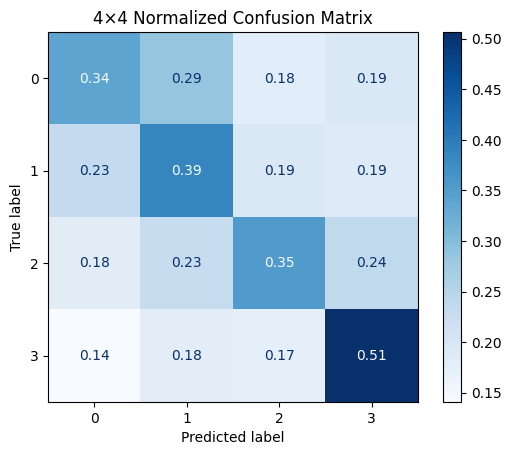

Epoch 1: Loss 1.1988, Acc 0.3483, Precision 0.2920, Recall 0.3960, F1 0.2354


Validating: 100%|██████████| 2909/2909 [00:26<00:00, 109.43it/s]


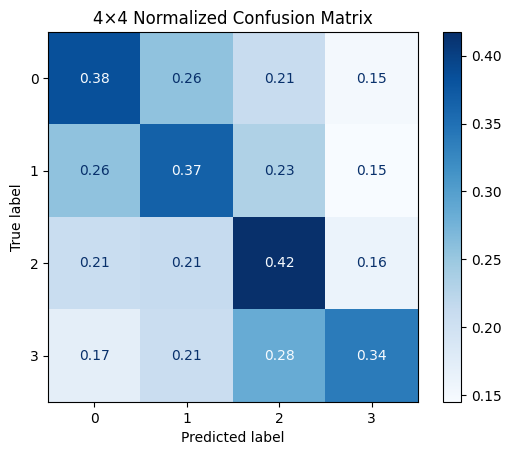

Epoch 2: Loss 1.0495, Acc 0.3820, Precision 0.2936, Recall 0.3762, F1 0.2463


Validating: 100%|██████████| 2909/2909 [00:26<00:00, 109.96it/s]


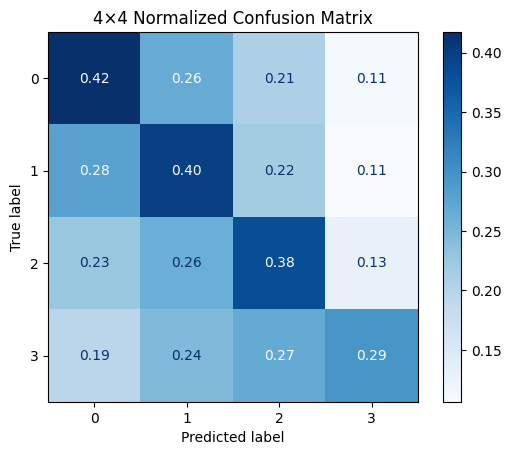

Epoch 3: Loss 0.8849, Acc 0.4112, Precision 0.2951, Recall 0.3727, F1 0.2570


Validating: 100%|██████████| 2909/2909 [00:26<00:00, 108.02it/s]


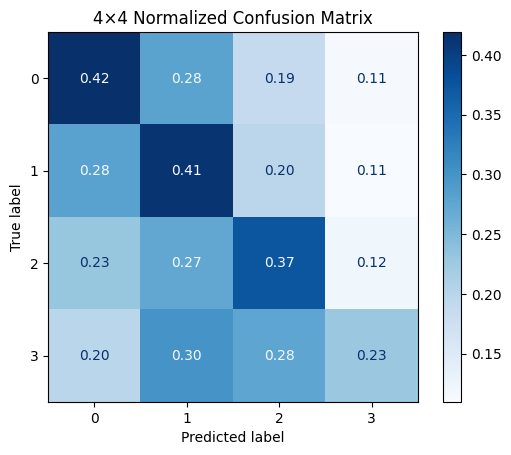

Epoch 4: Loss 0.7426, Acc 0.4134, Precision 0.2936, Recall 0.3584, F1 0.2556


Training:  71%|███████   | 3818/5362 [13:43<05:05,  5.05it/s]

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import ndcg_score  # correct import
from tqdm import tqdm
from collections import defaultdict

optimizer = optim.Adam(hybrid_ncf.parameters(), lr=0.001)

loss_by_epoch, accuracy_by_epoch, epoch_metrics_lists = [], [], []

for epoch in range(1, 6):
  hybrid_ncf.train()
  train_losses = []

  for batch in tqdm(train_loader, desc='Training'):
    user_ids = batch["user_id"].to(device)
    wid_idx_cand_encoder = batch["wid_idx_cand_encoder"].to(device)
    label = batch["label"].to(device)
    wid_idx_seq_encoder = batch["wid_idx_seq_encoder"].to(device)
    typ = batch["type"].to(device)
    time = batch["time"].to(device)
    lens = batch["true_len"].to(device)

    outputs = hybrid_ncf(user_ids, wid_idx_cand_encoder, wid_idx_seq_encoder, typ, time, lens)
    optimizer.zero_grad()

    # Flatten the label tensor for CrossEntropyLoss, which expects (N,) for multi-class classification
    flat_labels = label.view(-1)
    valid_mask = (flat_labels != -100)

    # Handle potential size mismatch between outputs and flattened labels/mask
    # This is a pragmatic fix for the IndexError, suggesting an underlying data/model alignment issue.
    if outputs.shape[0] != valid_mask.shape[0]:
        # If outputs are shorter, truncate the mask to match outputs' length
        # This means some labels at the end of the batch will be ignored.
        if outputs.shape[0] < valid_mask.shape[0]:
            valid_mask = valid_mask[:outputs.shape[0]]
            flat_labels = flat_labels[:outputs.shape[0]] # Also truncate labels to match
        # If outputs are longer, truncate outputs to match mask's length
        # This means some predictions at the end of outputs will be ignored.
        elif outputs.shape[0] > valid_mask.shape[0]:
            outputs = outputs[:valid_mask.shape[0], :]

    valid_labels = flat_labels[valid_mask]
    valid_outputs = outputs[valid_mask]

    # Only compute loss if there are valid samples after masking
    if valid_labels.numel() > 0:
        loss = F.cross_entropy(valid_outputs, valid_labels, weight=inv_freq_weights)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    else:
        # Handle case where a batch might have no valid labels after masking
        train_losses.append(0.0) # Or log a warning

  # --- Evaluation ---
  hybrid_ncf.eval()
  with torch.no_grad():
    total_predictions = np.array([])
    total_labels = np.array([])

    for batch in tqdm(val_loader, desc='Validating'): # Use val_loader for proper validation
        user_ids = batch["user_id"].to(device)
        wid_idx_cand_encoder = batch["wid_idx_cand_encoder"].to(device)
        label = batch["label"].to(device)
        wid_idx_seq_encoder = batch["wid_idx_seq_encoder"].to(device)
        typ = batch["type"].to(device)
        time = batch["time"].to(device)
        lens = batch["true_len"].to(device)

        outputs = hybrid_ncf(user_ids, wid_idx_cand_encoder, wid_idx_seq_encoder, typ, time, lens)

        probabilities = F.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        # Flatten labels and predictions, and remove padded values (-100)
        flat_labels = label.view(-1)
        valid_mask = (flat_labels != -100)

        # Apply similar size alignment during evaluation
        if outputs.shape[0] != valid_mask.shape[0]:
            if outputs.shape[0] < valid_mask.shape[0]:
                valid_mask = valid_mask[:outputs.shape[0]]
                flat_labels = flat_labels[:outputs.shape[0]]
            elif outputs.shape[0] > valid_mask.shape[0]:
                outputs = outputs[:valid_mask.shape[0], :]

        # Only process if there are valid samples after masking and alignment
        if valid_mask.any():
            pred_arr = predicted_classes[valid_mask].cpu().numpy()
            label_arr = flat_labels[valid_mask].cpu().numpy()

            total_predictions = np.concatenate([total_predictions, pred_arr])
            total_labels = np.concatenate([total_labels, label_arr])

  # --- Log Metrics ---
  curr_epoch_loss = np.mean(train_losses)
  loss_by_epoch.append(curr_epoch_loss)

  # Accuracy should be calculated only on valid labels
  accuracy = np.mean(total_predictions == total_labels) if len(total_labels) > 0 else 0.0
  accuracy_by_epoch.append(accuracy)

  if len(total_labels) > 0:
    epoch_metrics = evaluate_multiclass_confusion(total_labels, total_predictions, plot=True, verbose=False) # Plot only once
    macro_avg = epoch_metrics["macro_avg"]
    epoch_metrics_lists.append(epoch_metrics)
    print(f"Epoch {epoch}: Loss {curr_epoch_loss:.4f}, Acc {accuracy:.4f}, Precision {macro_avg['precision']:.4f}, Recall {macro_avg['recall']:.4f}, F1 {macro_avg['f1']:.4f}")
  else:
    # Handle case where validation set might be empty after filtering
    print(f"Epoch {epoch}: Loss {curr_epoch_loss:.4f}, Acc {accuracy:.4f} (No valid samples for metrics)")


## Testing the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

K = 5  # top-K candidates
all_hr = []
all_ndcg = []

all_test_preds = []
all_test_labels = []

hybrid_ncf.eval()
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)
        user_ids = batch['user_id']

        # Forward pass
        logits = hybrid_ncf(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)
        loss = F.cross_entropy(labels, logits, weights=inv_freq_weights)
        total_test_loss += loss.item()

        probs = torch.softmax(logits, dim=1)  # [B, C, num_classes]
        pred_classes = torch.argmax(probs, dim=1)  # [B, C]

              # Flatten labels and predictions, and remove padded values (-100)
        flat_labels = label.view(-1)
        valid_mask = (flat_labels != -100)

        # Apply similar size alignment during evaluation
        if outputs.shape[0] != valid_mask.shape[0]:
            if outputs.shape[0] < valid_mask.shape[0]:
                valid_mask = valid_mask[:outputs.shape[0]]
                flat_labels = flat_labels[:outputs.shape[0]]
            elif outputs.shape[0] > valid_mask.shape[0]:
                outputs = outputs[:valid_mask.shape[0], :]

        # Only process if there are valid samples after masking and alignment
        if valid_mask.any():
            pred_arr = predicted_classes[valid_mask].cpu().numpy()
            label_arr = flat_labels[valid_mask].cpu().numpy()

            total_predictions = np.concatenate([total_predictions, pred_arr])
            total_labels = np.concatenate([total_labels, label_arr])

        # User-level metrics for HR@K and NDCG@K
        for u in range(len(user_ids)):
            user_label = total_labels[u].cpu().numpy()
            user_probs = total_predictions[u].max(dim=1).values.cpu().numpy()  # max prob per candidate

            # Mask out padding candidates
            valid_mask = user_label >= 0
            if valid_mask.sum() == 0:
                continue

            user_label_valid = user_label[valid_mask]
            user_probs_valid = probs[valid_mask]

            # Rank candidates by predicted score
            ranked_idx = np.argsort(-user_probs_valid)
            top_k = ranked_idx[:min(K, len(ranked_idx))]
            top_k_labels = user_label_valid[top_k]

            # Hit Rate@K
            hit = int((top_k_labels > 0).any())
            all_hr.append(hit)

            # NDCG@K
            gains = 2**top_k_labels - 1
            discounts = np.log2(np.arange(2, len(top_k_labels)+2))
            dcg = np.sum(gains / discounts)

            # Ideal DCG
            ideal_labels = np.sort(user_label_valid)[::-1][:len(top_k_labels)]
            ideal_gains = 2**ideal_labels - 1
            idcg = np.sum(ideal_gains / discounts) if np.sum(ideal_gains) > 0 else 1.0

            ndcg = dcg / idcg
            all_ndcg.append(ndcg)

# Compute averages
test_loss = total_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)
hr_at_k = np.mean(all_hr)
ndcg_at_k = np.mean(all_ndcg)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Hit Rate@{K}: {hr_at_k:.4f}")
print(f"NDCG@{K}: {ndcg_at_k:.4f}")

In [ ]:
# @title
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

K = 5  # top-K candidates
all_hr = []
all_ndcg = []

all_test_preds = []
all_test_labels = []

model.eval()
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)
        user_ids = batch['user_id']

        # Forward pass
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)
        loss = criterion(logits[labels != -1], labels[labels != -1])
        total_test_loss += loss.item()

        probs = torch.softmax(logits, dim=2)  # [B, C, num_classes]
        pred_classes = torch.argmax(probs, dim=2)  # [B, C]

        # Flattened metrics for overall accuracy, F1
        mask = labels != -1
        all_test_preds.extend(pred_classes[mask].cpu().numpy())
        all_test_labels.extend(labels[mask].cpu().numpy())

        # User-level metrics for HR@K and NDCG@K
        for u in range(len(user_ids)):
            user_label = labels[u].cpu().numpy()
            user_probs = probs[u].max(dim=1).values.cpu().numpy()  # max prob per candidate

            # Mask out padding candidates
            valid_mask = user_label >= 0
            if valid_mask.sum() == 0:
                continue

            user_label_valid = user_label[valid_mask]
            user_probs_valid = user_probs[valid_mask]

            # Rank candidates by predicted score
            ranked_idx = np.argsort(-user_probs_valid)
            top_k = ranked_idx[:min(K, len(ranked_idx))]
            top_k_labels = user_label_valid[top_k]

            # Hit Rate@K
            hit = int((top_k_labels > 0).any())
            all_hr.append(hit)

            # NDCG@K
            gains = 2**top_k_labels - 1
            discounts = np.log2(np.arange(2, len(top_k_labels)+2))
            dcg = np.sum(gains / discounts)

            # Ideal DCG
            ideal_labels = np.sort(user_label_valid)[::-1][:len(top_k_labels)]
            ideal_gains = 2**ideal_labels - 1
            idcg = np.sum(ideal_gains / discounts) if np.sum(ideal_gains) > 0 else 1.0

            ndcg = dcg / idcg
            all_ndcg.append(ndcg)

# Compute averages
test_loss = total_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)
hr_at_k = np.mean(all_hr)
ndcg_at_k = np.mean(all_ndcg)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Hit Rate@{K}: {hr_at_k:.4f}")
print(f"NDCG@{K}: {ndcg_at_k:.4f}")